In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

In [10]:
df = pd.read_csv('sms+spam+collection/SMSSpamCollection', sep ='\t', header = None)

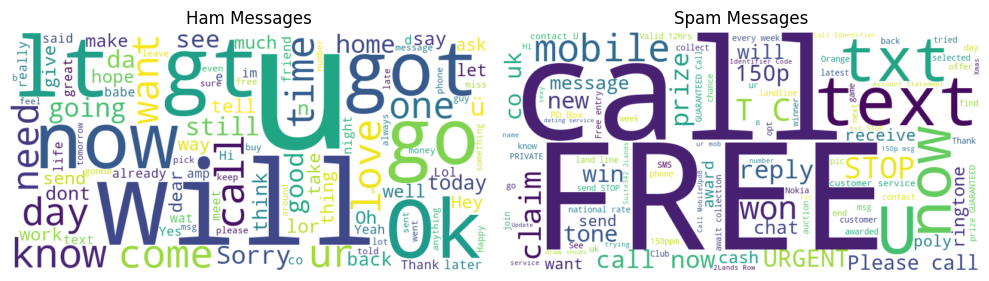

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

ham_text = ' '.join(df[df.iloc[:, 0] == 'ham'].iloc[:, 1].astype(str))
wordcloud_ham = WordCloud(width=800, height=400, 
                        background_color='white',
                        max_words=100,
                        random_state=42).generate(ham_text)

plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis('off')
plt.title('Ham Messages')

plt.subplot(1, 2, 2)

spam_text = ' '.join(df[df.iloc[:, 0] == 'spam'].iloc[:, 1].astype(str))
wordcloud_spam = WordCloud(width=800, height=400,
                         background_color='white', 
                         max_words=100,
                         random_state=42).generate(spam_text)

plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title('Spam Messages')

plt.tight_layout()
plt.show()

In [2]:
def load_data():
    """Load the prepared data splits"""
    train = pd.read_csv('train.csv')
    validation = pd.read_csv('validation.csv')
    test = pd.read_csv('test.csv')
    return train, validation, test

def handle_nan_data(data, text_column=1):
    """Handling NaN values"""
    data = data.copy()
    data.iloc[:, text_column] = data.iloc[:, text_column].fillna('')
    return data

def fit_model(model, train_data, text_column=1, label_column=0):
    """Fit a model on training data"""
    # Handling NaNs
    train_data = handle_nan_data(train_data, text_column)
    
    # Create and fit TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train = vectorizer.fit_transform(train_data.iloc[:, text_column])
    y_train = train_data.iloc[:, label_column]
    
    # Fit the model
    model.fit(X_train, y_train)
    
    return model, vectorizer

def score_model(model, vectorizer, data, text_column=1):
    """Score a model on given data"""
    # Clean text data
    data = handle_nan_data(data, text_column)
    X = vectorizer.transform(data.iloc[:, text_column])
    return model.predict(X)

def evaluate_predictions(y_true, y_pred, dataset_name=""):
    """Evaluate model predictions with comprehensive metrics"""
    print(f"\nEvaluation on {dataset_name} dataset:")
    
    # Calculate all metrics
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Print all metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (spam): {report['1']['precision']:.4f}")
    print(f"Recall (spam): {report['1']['recall']:.4f}")
    print(f"F1-score (spam): {report['1']['f1-score']:.4f}")
    
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Return F1-score for spam class (used for model comparison)
    return report['1']['f1-score']

def fine_tune_model(model, param_grid, train_data, validation_data, text_column=1, label_column=0):
    """Fine-tune model hyperparameters using the validation set"""
    # Handle NaN values
    train_data = handle_nan_data(train_data, text_column)
    validation_data = handle_nan_data(validation_data, text_column)
    
    # Create TF-IDF features
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train = vectorizer.fit_transform(train_data.iloc[:, text_column])
    y_train = train_data.iloc[:, label_column]
    
    X_val = vectorizer.transform(validation_data.iloc[:, text_column])
    y_val = validation_data.iloc[:, label_column]
    
    # Perform grid search using validation set with F1 score as metric
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model on validation data
    val_pred = best_model.predict(X_val)
    val_f1 = evaluate_predictions(y_val, val_pred, "Validation")
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Validation F1-score: {val_f1:.4f}")
    
    return best_model, vectorizer

def benchmark_models(train_data, validation_data, test_data, text_column=1, label_column=0):
    """Train and evaluate three benchmark models with hyperparameter tuning using validation set"""
    # Initialize models and their hyperparameter grids
    models = {
        'Naive Bayes': (MultinomialNB(), {'alpha': [0.1, 0.5, 1.0]}),
        'Linear SVM': (LinearSVC(random_state=42), {'C': [0.01, 0.1, 1, 10]}),
        'Random Forest': (RandomForestClassifier(n_estimators=100, random_state=42), 
                          {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]})
    }
    
    results = {}

    for name, (model, param_grid) in models.items():
        print(f"\nFine-tuning {name}...")

        # Fine-tune model using validation set
        best_model, vectorizer = fine_tune_model(model, param_grid, train_data, validation_data, text_column, label_column)
        
        # Score and evaluate on test data
        test_pred = score_model(best_model, vectorizer, test_data, text_column)
        test_f1 = evaluate_predictions(test_data.iloc[:, label_column], test_pred, f"Test ({name})")
        
        results[name] = {
            'model': best_model,
            'vectorizer': vectorizer,
            'f1_score': test_f1
        }
        
        print(f"{name} Test F1-score: {test_f1:.4f}")
    
    # Select best model based on F1-score
    best_model_name = max(results.items(), key=lambda x: x[1]['f1_score'])[0]
    print(f"\nBest model: {best_model_name} (F1-score: {results[best_model_name]['f1_score']:.4f})")
    
    return results[best_model_name]['model'], results[best_model_name]['vectorizer']

In [3]:
train_data, validation_data, test_data = load_data()
best_model, best_vectorizer = benchmark_models(train_data, validation_data, test_data)


Fine-tuning Naive Bayes...

Evaluation on Validation dataset:
Accuracy: 0.9857
Precision (spam): 0.9926
Recall (spam): 0.9000
F1-score (spam): 0.9441

Confusion Matrix:
[[964   1]
 [ 15 135]]
Best parameters: {'alpha': 0.1}
Validation F1-score: 0.9441

Evaluation on Test (Naive Bayes) dataset:
Accuracy: 0.9785
Precision (spam): 0.9921
Recall (spam): 0.8456
F1-score (spam): 0.9130

Confusion Matrix:
[[965   1]
 [ 23 126]]
Naive Bayes Test F1-score: 0.9130

Fine-tuning Linear SVM...

Evaluation on Validation dataset:
Accuracy: 0.9794
Precision (spam): 0.9704
Recall (spam): 0.8733
F1-score (spam): 0.9193

Confusion Matrix:
[[961   4]
 [ 19 131]]
Best parameters: {'C': 10}
Validation F1-score: 0.9193

Evaluation on Test (Linear SVM) dataset:
Accuracy: 0.9821
Precision (spam): 0.9778
Recall (spam): 0.8859
F1-score (spam): 0.9296

Confusion Matrix:
[[963   3]
 [ 17 132]]
Linear SVM Test F1-score: 0.9296

Fine-tuning Random Forest...

Evaluation on Validation dataset:
Accuracy: 0.9704
Precis

To conclude, we can see that the best model is Linear SVM, with test dataset evaluation metrics being:
- Accuracy: 0.9821
- Precision (spam): 0.9778
- Recall (spam): 0.8859
- F1-score (spam): 0.9296